# SAT5165 Spring 2023 - Course Project | Group 12
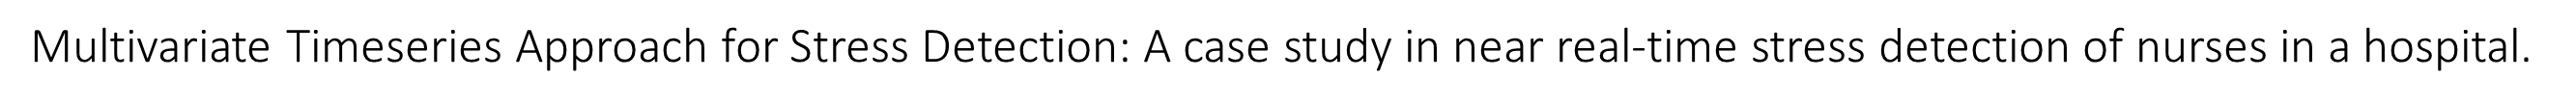

## Pre-Pocessing and Data Preperation

Installing dependencies and Importing required packages

In [ ]:
!pip install pyts
!pip install tsextract
!pip install scipy==1.8.1
!pip install tensorflow-addons
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tsextract.feature_extraction.extract import build_features, build_features_forecast
from tsextract.domain.statistics import mean, median, std, min, max, kurtosis, skew, rmse 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
from functools import partial
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
import time
from skimage.transform import resize
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from keras.utils.np_utils import to_categorical  
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import np_utils

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Loading Data

Source: https://github.com/italha-d/Stress-Predict-Dataset

In [ ]:
df = pd.read_csv('/content/Improved_All_Combined_hr_rsp_binary.csv')
df.rename({'Time(sec)': 'Date'}, axis=1, inplace=True)
df['Date'] = pd.to_datetime(df["Date"], unit='s')
df = df.set_index('Date')

In [ ]:
df.head()

,Participant,HR,respr,Label
Date,,,,
2022-02-07 09:53:03,2,118.00,12.127693,0
2022-02-07 09:53:04,2,113.50,12.127693,0
2022-02-07 09:53:05,2,93.00,12.127693,0
2022-02-07 09:53:06,2,93.25,12.127693,0
2022-02-07 09:53:07,2,86.40,12.127693,0


Setting Window size 60 for Lag Features

In [ ]:
window = 60

### Feature extraction

  

*   Building Features for Heartrate Column




In [ ]:
features_request = {
    "window": [window],
    "window_statistic": [window, mean], 
    # "window_statistic":[window, min],
    # "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    # "window_statistic": [window, rmse] 
}

build_df_hr = build_features(df.HR, features_request, target_lag=window, include_tzero=True)

features_request = {
    "window": [window],
    # "window_statistic": [window, mean], 
    "window_statistic":[window, min],
    # "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    # "window_statistic": [window, rmse] 
}

build_df_hr_min = build_features(df.HR, features_request, target_lag=window, include_tzero=True)
build_df_hr['window_statistic_'+str(window)+'_min'] = build_df_hr_min['window_statistic_'+str(window)+'_min']

features_request = {
    "window": [window],
    # "window_statistic": [window, mean], 
    # "window_statistic":[window, min],
    "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    # "window_statistic": [window, rmse] 
}

build_df_hr_max = build_features(df.HR, features_request, target_lag=window, include_tzero=True)
build_df_hr['window_statistic_'+str(window)+'_max'] = build_df_hr_max['window_statistic_'+str(window)+'_max']

features_request = {
    "window": [window],
    # "window_statistic": [window, mean], 
    # "window_statistic":[window, min],
    # "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    "window_statistic": [window, rmse] 
}

build_df_hr_rmse = build_features(df.HR, features_request, target_lag=window, include_tzero=True)
build_df_hr['window_statistic_'+str(window)+'_rmse'] = build_df_hr_rmse['window_statistic_'+str(window)+'_rmse']

build_df_hr.rename({'tzero': 'HR'}, axis=1, inplace=True)
joined_hr = pd.merge(build_df_hr, df, on=['Date', 'HR'], how='left')

In [ ]:
joined_hr.columns

Index(['T-60', 'T-59', 'T-58', 'T-57', 'T-56', 'T-55', 'T-54', 'T-53', 'T-52',
       'T-51', 'T-50', 'T-49', 'T-48', 'T-47', 'T-46', 'T-45', 'T-44', 'T-43',
       'T-42', 'T-41', 'T-40', 'T-39', 'T-38', 'T-37', 'T-36', 'T-35', 'T-34',
       'T-33', 'T-32', 'T-31', 'T-30', 'T-29', 'T-28', 'T-27', 'T-26', 'T-25',
       'T-24', 'T-23', 'T-22', 'T-21', 'T-20', 'T-19', 'T-18', 'T-17', 'T-16',
       'T-15', 'T-14', 'T-13', 'T-12', 'T-11', 'T-10', 'T-9', 'T-8', 'T-7',
       'T-6', 'T-5', 'T-4', 'T-3', 'T-2', 'T-1', 'window_statistic_60_mean',
       'difference_statistic_60_1_std', 'HR', 'Target_Tplus60',
       'window_statistic_60_min', 'window_statistic_60_max',
       'window_statistic_60_rmse', 'Participant', 'respr', 'Label'],
      dtype='object')

In [ ]:
joined_hr.head()

,T-60,T-59,T-58,T-57,T-56,T-55,T-54,T-53,T-52,T-51,...,window_statistic_60_mean,difference_statistic_60_1_std,HR,Target_Tplus60,window_statistic_60_min,window_statistic_60_max,window_statistic_60_rmse,Participant,respr,Label
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-07 10:27:14,72.28,72.37,72.45,72.52,72.55,72.58,72.60,72.60,72.65,72.68,...,73.085500,0.170500,72.43,73.27,71.55,74.85,73.091667,2,10.449999,0
2022-02-07 10:27:15,72.37,72.45,72.52,72.55,72.58,72.60,72.60,72.65,72.68,72.67,...,73.088000,0.172747,72.20,73.70,71.55,74.85,73.094142,2,10.485555,0
2022-02-07 10:27:16,72.45,72.52,72.55,72.58,72.60,72.60,72.65,72.68,72.67,72.67,...,73.085167,0.174679,71.98,74.12,71.55,74.85,73.091340,2,10.459955,0
2022-02-07 10:27:17,72.52,72.55,72.58,72.60,72.60,72.65,72.68,72.67,72.67,72.67,...,73.077333,0.175291,71.85,74.45,71.55,74.85,73.083600,2,10.459955,0
2022-02-07 10:27:18,72.55,72.58,72.60,72.60,72.65,72.68,72.67,72.67,72.67,72.67,...,73.066167,0.175362,71.78,74.75,71.55,74.85,73.072570,2,10.459955,0


*   Building Features for Respiratory Date Column

In [ ]:
features_request = {
    "window": [window],
    "window_statistic": [window, mean], 
    # "window_statistic":[window, min],
    # "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    # "window_statistic": [window, rmse] 
}

build_df_respr = build_features(df.respr, features_request, target_lag=window, include_tzero=True)

features_request = {
    "window": [window],
    # "window_statistic": [window, mean], 
    "window_statistic":[window, min],
    # "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    # "window_statistic": [window, rmse] 
}

build_df_respr_min = build_features(df.respr, features_request, target_lag=window, include_tzero=True)
build_df_respr['window_statistic_'+str(window)+'_min'] = build_df_respr_min['window_statistic_'+str(window)+'_min']

features_request = {
    "window": [window],
    # "window_statistic": [window, mean], 
    # "window_statistic":[window, min],
    "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    # "window_statistic": [window, rmse] 
}

build_df_respr_max = build_features(df.respr, features_request, target_lag=window, include_tzero=True)
build_df_respr['window_statistic_'+str(window)+'_max'] = build_df_respr_max['window_statistic_'+str(window)+'_max']

features_request = {
    "window": [window],
    # "window_statistic": [window, mean], 
    # "window_statistic":[window, min],
    # "window_statistic":[window, max],
    "difference_statistic": [window, 1, std],
    "window_statistic": [window, rmse] 
}

build_df_respr_rmse = build_features(df.respr, features_request, target_lag=window, include_tzero=True)
build_df_respr['window_statistic_'+str(window)+'_rmse'] = build_df_respr_rmse['window_statistic_'+str(window)+'_rmse']

build_df_respr.rename({'tzero': 'respr'}, axis=1, inplace=True)
joined_respr = pd.merge(build_df_respr, df, on=['Date', 'respr'], how='left')

In [ ]:
joined_respr.head()

,T-60,T-59,T-58,T-57,T-56,T-55,T-54,T-53,T-52,T-51,...,window_statistic_60_mean,difference_statistic_60_1_std,respr,Target_Tplus60,window_statistic_60_min,window_statistic_60_max,window_statistic_60_rmse,Participant,HR,Label
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-07 09:54:03,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,...,12.127693,0.0,12.127693,11.295958,12.127693,12.127693,12.127693,2,72.62,0
2022-02-07 09:54:04,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,...,12.127693,0.0,12.127693,11.203369,12.127693,12.127693,12.127693,2,71.98,0
2022-02-07 09:54:05,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,...,12.127693,0.0,12.127693,11.112284,12.127693,12.127693,12.127693,2,72.30,0
2022-02-07 09:54:06,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,...,12.127693,0.0,12.127693,11.022669,12.127693,12.127693,12.127693,2,71.87,0
2022-02-07 09:54:07,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,12.127693,...,12.127693,0.0,12.127693,11.048266,12.127693,12.127693,12.127693,2,72.03,0


*   Combining Features

In [ ]:
merged_index = joined_respr[joined_respr.index.isin(joined_hr.index)].index

In [ ]:
merged_df = pd.merge(joined_respr, joined_hr, on=['Date', 'Participant', 'HR', 'respr', 'Label'], how='left').dropna()
merged_df.head()

,T-60_x,T-59_x,T-58_x,T-57_x,T-56_x,T-55_x,T-54_x,T-53_x,T-52_x,T-51_x,...,T-4_y,T-3_y,T-2_y,T-1_y,window_statistic_60_mean_y,difference_statistic_60_1_std_y,Target_Tplus60_y,window_statistic_60_min_y,window_statistic_60_max_y,window_statistic_60_rmse_y
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-07 10:27:14,9.350428,9.350428,9.414428,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,...,73.32,73.12,72.90,72.67,73.085500,0.170500,73.27,71.55,74.85,73.091667
2022-02-07 10:27:15,9.350428,9.414428,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,...,73.12,72.90,72.67,72.43,73.088000,0.172747,73.70,71.55,74.85,73.094142
2022-02-07 10:27:16,9.414428,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,9.461361,...,72.90,72.67,72.43,72.20,73.085167,0.174679,74.12,71.55,74.85,73.091340
2022-02-07 10:27:17,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,9.461361,9.470088,...,72.67,72.43,72.20,71.98,73.077333,0.175291,74.45,71.55,74.85,73.083600
2022-02-07 10:27:18,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,9.461361,9.470088,9.480755,...,72.43,72.20,71.98,71.85,73.066167,0.175362,74.75,71.55,74.85,73.072570


In [ ]:
len(merged_df)-len(merged_df.drop_duplicates())

0

In [ ]:
merged_df.head()

,T-60_x,T-59_x,T-58_x,T-57_x,T-56_x,T-55_x,T-54_x,T-53_x,T-52_x,T-51_x,...,T-4_y,T-3_y,T-2_y,T-1_y,window_statistic_60_mean_y,difference_statistic_60_1_std_y,Target_Tplus60_y,window_statistic_60_min_y,window_statistic_60_max_y,window_statistic_60_rmse_y
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-07 10:27:14,9.350428,9.350428,9.414428,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,...,73.32,73.12,72.90,72.67,73.085500,0.170500,73.27,71.55,74.85,73.091667
2022-02-07 10:27:15,9.350428,9.414428,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,...,73.12,72.90,72.67,72.43,73.088000,0.172747,73.70,71.55,74.85,73.094142
2022-02-07 10:27:16,9.414428,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,9.461361,...,72.90,72.67,72.43,72.20,73.085167,0.174679,74.12,71.55,74.85,73.091340
2022-02-07 10:27:17,9.414428,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,9.461361,9.470088,...,72.67,72.43,72.20,71.98,73.077333,0.175291,74.45,71.55,74.85,73.083600
2022-02-07 10:27:18,9.414428,9.382428,9.382428,9.382428,9.382428,9.425094,9.450694,9.461361,9.470088,9.480755,...,72.43,72.20,71.98,71.85,73.066167,0.175362,74.75,71.55,74.85,73.072570


### Splitting Data

3 Fold Split - 70:15:15 (Train:Test:Validation)

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(merged_df, 
                                                          merged_df['Label'],
                                                          shuffle = False, 
                                                          test_size=0.15, 
                                                          random_state=42
                                                          )
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  shuffle = False, 
                                                  test_size=0.15/0.85, 
                                                  random_state=42)

print("Train Percentage:",str(len(y_train)*100/len(merged_df['Label'])))
print("Validation Percentage:",str(len(y_val)*100/len(merged_df['Label'])))
print("Test Percentage:",str(len(y_test)*100/len(merged_df['Label'])))

Train Percentage: 69.99898433099729
Validation Percentage: 15.000507834501352
Test Percentage: 15.000507834501352


In [ ]:
X_train = X_train.drop(
    ['Target_Tplus'+str(window)+'_x', 'Target_Tplus'+str(window)+'_y'], axis=1)
X_test = X_test.drop(
    ['Target_Tplus'+str(window)+'_x', 'Target_Tplus'+str(window)+'_y'], axis=1)
X_val = X_val.drop(
    ['Target_Tplus'+str(window)+'_x', 'Target_Tplus'+str(window)+'_y'], axis=1)

Reformatting Data to to be used by Time series Dep Learning Models 

In [ ]:
train_sequences = []

for row in X_train.iterrows():
  row_df = pd.DataFrame()
  row_df['respr'] = list(list(row)[1][:window])
  row_df['hr'] = list(list(row)[1][window+9:-5])
  train_sequences.append(row_df.to_numpy())

test_sequences = []

for row in X_test.iterrows():
  row_df = pd.DataFrame()
  row_df['respr'] = list(list(row)[1][:window])
  row_df['hr'] = list(list(row)[1][window+9:-5])
  test_sequences.append(row_df.to_numpy())

val_sequences = []

for row in X_val.iterrows():
  row_df = pd.DataFrame()
  row_df['respr'] = list(list(row)[1][:window])
  row_df['hr'] = list(list(row)[1][window+9:-5])
  val_sequences.append(row_df.to_numpy())

### Standardize features by Scaling

In [ ]:
x_train = np.array(train_sequences)
x_test = np.array(test_sequences)
x_val = np.array(val_sequences)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train.reshape((x_train.shape[0]*window, 2))).reshape((x_train.shape[0],window, 2))
x_test = scaler.transform(x_test.reshape((x_test.shape[0]*window, 2))).reshape((x_test.shape[0],window, 2))
x_val = scaler.transform(x_val.reshape((x_val.shape[0]*window, 2))).reshape((x_val.shape[0],window, 2))

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(75811, 60, 2)
(16246, 60, 2)
(16246, 60, 2)
(75811, 60, 2)
(16246, 60, 2)
(16246, 60, 2)


In [ ]:
X_train_ml = X_train
X_test_ml = X_test
X_val_ml = X_val

In [ ]:
X_train = x_train.reshape(x_train.shape[0], 1, window, 2)
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)

X_test = x_test.reshape(x_test.shape[0], 1, window, 2)
X_test = X_test.astype('float32')
X_test /= np.amax(X_test)

X_val = x_val.reshape(x_val.shape[0], 1, window, 2)
X_val = X_val.astype('float32')
X_val /= np.amax(X_val)

### Calculating Weights based on class distribution

For passing to Deep Learning Models to prevent overfitting on majority Class

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.7435512662076541, 1: 1.5264779317010309}

### Utility Functions for Plotting Training performance 

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
def plot_hist_sparse(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Models

### Deep Learning Models

#### Convolutional Neural Network

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    # conv1 = Dropout(0.5)(conv1)
    conv1 = keras.layers.LeakyReLU()(conv1)
    

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.LeakyReLU()(conv2)
    # conv2 = Dropout(0.5)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.LeakyReLU()(conv3)
    # conv3 = Dropout(0.5)(conv3)

    conv4 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.LeakyReLU()(conv4)
    # conv4 = Dropout(0.5)(conv4)

    conv5 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv4)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.LeakyReLU()(conv5)

    conv6 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv5)
    conv6 = keras.layers.BatchNormalization()(conv6)
    conv6 = keras.layers.LeakyReLU()(conv6)

    conv7 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv6)
    conv7 = keras.layers.BatchNormalization()(conv7)
    conv7 = keras.layers.LeakyReLU()(conv7)
    

    gap = keras.layers.GlobalMaxPool2D()(conv7)
    gap = Dropout(0.6)(gap)
    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])

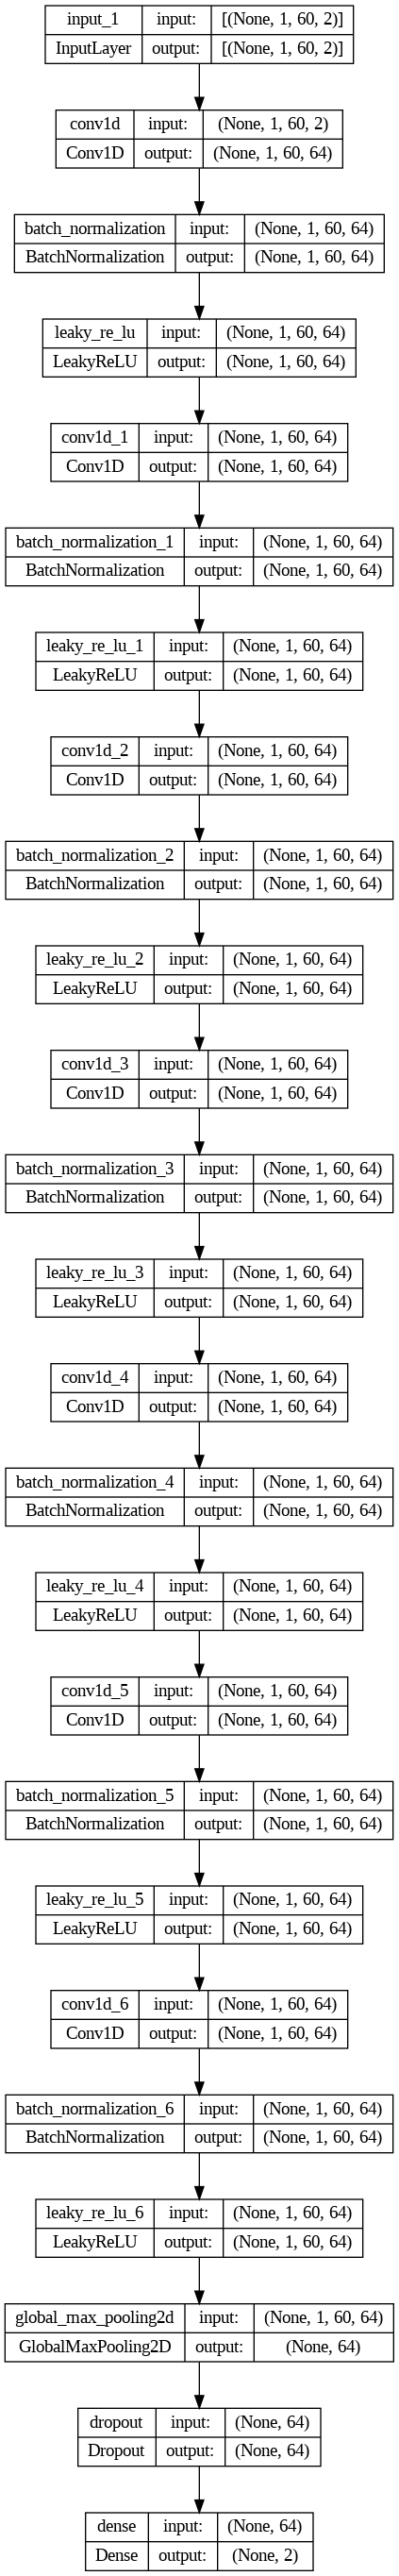

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 250
batch_size = 128

callbacks = [
    # keras.callbacks.ModelCheckpoint(
    #     "best_model.h5", save_best_only=True, monitor="val_loss"
    # ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
with tf.device('/device:gpu:0'):
  history = model.fit(
      X_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks,
      class_weight = class_weights,
      validation_data=(X_val,y_val),
      verbose=1,
  )

Epoch 1/250
593/593 [==============================] - 14s 9ms/step - loss: 0.7104 - sparse_categorical_accuracy: 0.5799 - val_loss: 0.7990 - val_sparse_categorical_accuracy: 0.4146 - lr: 0.0010
Epoch 2/250
593/593 [==============================] - 6s 9ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.6146 - val_loss: 0.7641 - val_sparse_categorical_accuracy: 0.4490 - lr: 0.0010
Epoch 3/250
593/593 [==============================] - 6s 10ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.6267 - val_loss: 0.7777 - val_sparse_categorical_accuracy: 0.4997 - lr: 0.0010
Epoch 4/250
593/593 [==============================] - 5s 8ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.6315 - val_loss: 0.8907 - val_sparse_categorical_accuracy: 0.5163 - lr: 0.0010
Epoch 5/250
593/593 [==============================] - 6s 10ms/step - loss: 0.6268 - sparse_categorical_accuracy: 0.6356 - val_loss: 0.7721 - val_sparse_categorical_accuracy: 0.5276 - lr: 0.0010
Epoch 6/250
593/593 [======

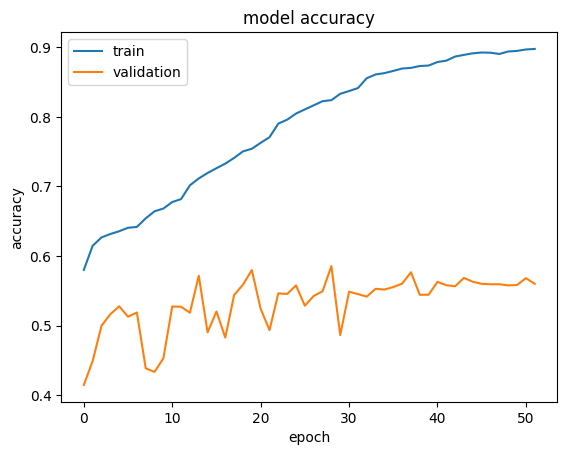

In [ ]:
plot_hist_sparse(history)

In [ ]:
model.evaluate(X_test,y_test,verbose=1)

508/508 [==============================] - 2s 3ms/step - loss: 6.6600 - sparse_categorical_accuracy: 0.6105


[6.660016059875488, 0.6104887127876282]

In [ ]:
pred = model.predict(X_test)
print(classification_report(y_test, np.argmax(pred,axis=1)))

508/508 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.67      0.81      0.73     10731
           1       0.38      0.23      0.29      5515

    accuracy                           0.61     16246
   macro avg       0.52      0.52      0.51     16246
weighted avg       0.57      0.61      0.58     16246



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

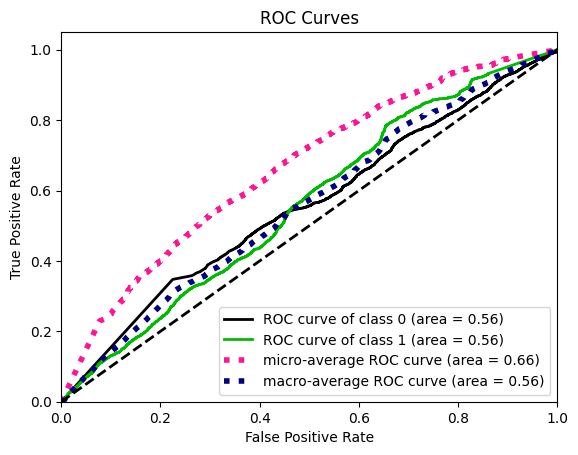

In [ ]:
skplt.metrics.plot_roc(y_test, pred)

#### LSTM (Long short-term memory networks)

In [ ]:
model2 = keras.Sequential()
model2.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model2.add(keras.layers.Dropout(rate=0.5))
model2.add(keras.layers.Dense(units=64, activation=partial(tf.nn.leaky_relu, alpha=0.01)))
model2.add(keras.layers.Dense(units=16, activation=partial(tf.nn.leaky_relu, alpha=0.01)))
model2.add(keras.layers.Dense(2, activation='softmax'))

model2.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['sparse_categorical_accuracy']
)

In [ ]:
with tf.device('/device:gpu:0'):
  history = model2.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks,
      class_weight = class_weights,
      validation_data=(x_val,y_val),
      verbose=1,
  )

Epoch 1/250
593/593 [==============================] - 13s 13ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.6097 - val_loss: 0.7538 - val_sparse_categorical_accuracy: 0.5014 - lr: 0.0010
Epoch 2/250
593/593 [==============================] - 7s 11ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.6143 - val_loss: 0.7838 - val_sparse_categorical_accuracy: 0.4538 - lr: 0.0010
Epoch 3/250
593/593 [==============================] - 7s 11ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.7649 - val_sparse_categorical_accuracy: 0.5230 - lr: 0.0010
Epoch 4/250
593/593 [==============================] - 7s 11ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.6306 - val_loss: 0.7812 - val_sparse_categorical_accuracy: 0.4919 - lr: 0.0010
Epoch 5/250
593/593 [==============================] - 7s 11ms/step - loss: 0.6410 - sparse_categorical_accuracy: 0.6295 - val_loss: 0.7530 - val_sparse_categorical_accuracy: 0.4940 - lr: 0.0010
Epoch 6/250
593/593 [===

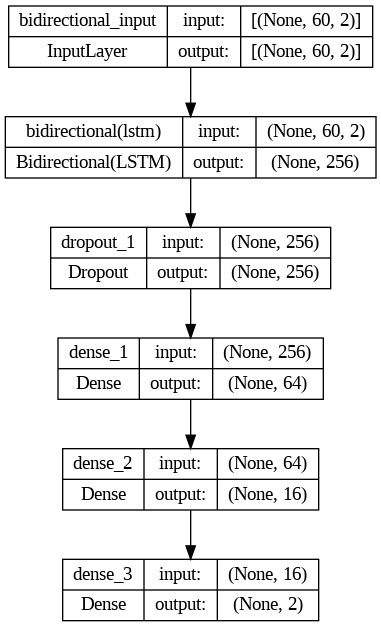

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True)

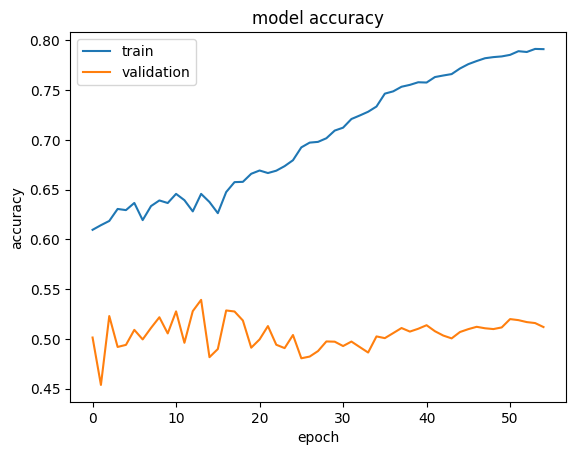

In [ ]:
plot_hist_sparse(history)

In [ ]:
model2.evaluate(x_test,y_test,verbose=1)

508/508 [==============================] - 3s 6ms/step - loss: 1.3194 - sparse_categorical_accuracy: 0.5247


[1.319434642791748, 0.5247445702552795]

In [ ]:
pred = model2.predict(x_test)
print(classification_report(y_test, np.argmax(pred,axis=1)))

508/508 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.68      0.53      0.59     10731
           1       0.36      0.52      0.43      5515

    accuracy                           0.52     16246
   macro avg       0.52      0.52      0.51     16246
weighted avg       0.57      0.52      0.54     16246



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

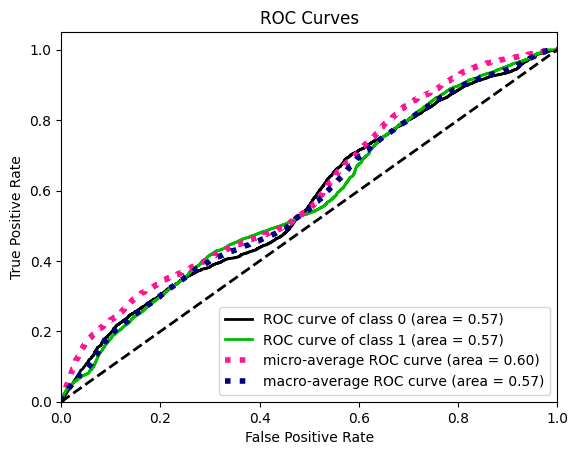

In [ ]:
skplt.metrics.plot_roc(y_test,pred)

#### LSTM (Long short-term memory networks)

In [ ]:
model2 = keras.Sequential()
model2.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]],
          kernel_regularizer=regularizers.L2(0.01),
          recurrent_regularizer=regularizers.L2(0.01),
          return_sequences=True
      )
    )
)
model2.add(keras.layers.Dropout(rate=0.1))
model2.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=64,
          kernel_regularizer=regularizers.L2(0.01),
          recurrent_regularizer=regularizers.L2(0.01)
      )
    )
)
model2.add(keras.layers.Dropout(rate=0.1))
model2.add(keras.layers.Dense(units=64, activation=partial(tf.nn.leaky_relu, alpha=0.01)))
model2.add(keras.layers.Dropout(rate=0.5))
model2.add(keras.layers.Dense(units=16, activation=partial(tf.nn.leaky_relu, alpha=0.01)))
model2.add(keras.layers.Dense(2, activation='softmax'))

model2.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['sparse_categorical_accuracy']
)

In [ ]:
with tf.device('/device:gpu:0'):
  history = model2.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks,
      class_weight = class_weights,
      validation_data=(x_val,y_val),
      verbose=1,
  )

Epoch 1/250
593/593 [==============================] - 23s 22ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.5265 - val_loss: 0.7273 - val_sparse_categorical_accuracy: 0.4125 - lr: 0.0010
Epoch 2/250
593/593 [==============================] - 11s 19ms/step - loss: 0.6754 - sparse_categorical_accuracy: 0.5289 - val_loss: 0.7134 - val_sparse_categorical_accuracy: 0.4743 - lr: 0.0010
Epoch 3/250
593/593 [==============================] - 12s 20ms/step - loss: 0.6718 - sparse_categorical_accuracy: 0.5557 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.5033 - lr: 0.0010
Epoch 4/250
593/593 [==============================] - 12s 20ms/step - loss: 0.6678 - sparse_categorical_accuracy: 0.5749 - val_loss: 0.7048 - val_sparse_categorical_accuracy: 0.5544 - lr: 0.0010
Epoch 5/250
593/593 [==============================] - 12s 20ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.5839 - val_loss: 0.7620 - val_sparse_categorical_accuracy: 0.4199 - lr: 0.0010
Epoch 6/250
593/593 

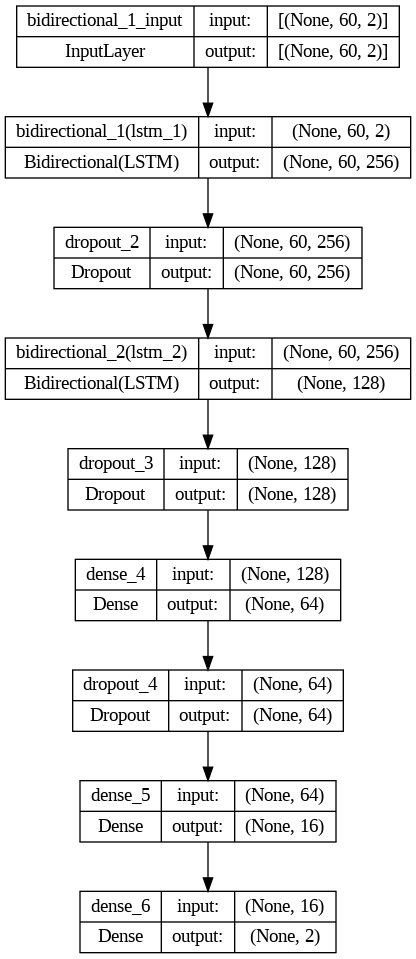

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True)

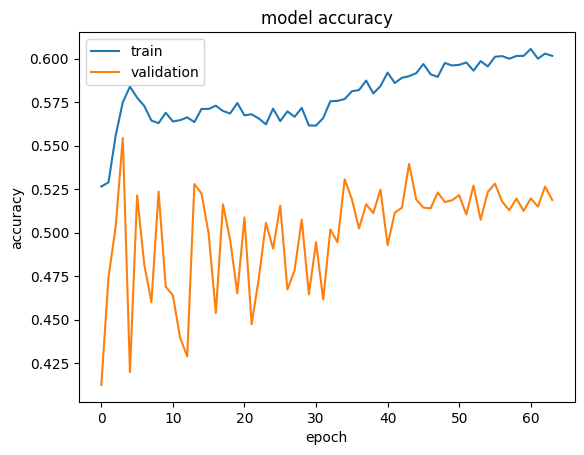

In [ ]:
plot_hist_sparse(history)

In [ ]:
model2.evaluate(x_test,y_test,verbose=1)

508/508 [==============================] - 4s 9ms/step - loss: 0.7093 - sparse_categorical_accuracy: 0.5163


[0.7093320488929749, 0.5163117051124573]

In [ ]:
pred = model2.predict(x_test)
print(classification_report(y_test, np.argmax(pred,axis=1)))

508/508 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

           0       0.66      0.56      0.60     10731
           1       0.34      0.43      0.38      5515

    accuracy                           0.52     16246
   macro avg       0.50      0.50      0.49     16246
weighted avg       0.55      0.52      0.53     16246



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

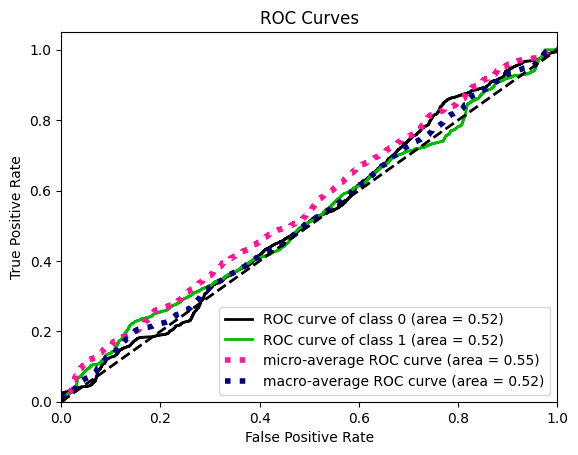

In [ ]:
skplt.metrics.plot_roc(y_test, pred)

#### LSTM + Focal Loss

In [ ]:
def focal_loss_custom(alpha, gamma):

  def binary_focal_loss(y_true, y_pred):

    fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)

    y_true_K = K.ones_like(y_true)

    focal_loss = fl(y_true, y_pred)

    return focal_loss

  return binary_focal_loss

In [ ]:
def recall_m(y_true, y_pred):
   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
   possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
   recall = true_positives / (possible_positives + K.epsilon())
   return recall
def precision_m(y_true, y_pred):
   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
   predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
   precision = true_positives / (predicted_positives + K.epsilon())
   return precision
def f1_m(y_true, y_pred):
   precision = precision_m(y_true, y_pred)
   recall = recall_m(y_true, y_pred)
   return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model2 = keras.Sequential()
model2.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]],
          kernel_regularizer=regularizers.L2(0.01),
          recurrent_regularizer=regularizers.L2(0.01),
          return_sequences=True
      )
    )
)
model2.add(keras.layers.Dropout(rate=0.1))
model2.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=64,
          kernel_regularizer=regularizers.L2(0.01),
          recurrent_regularizer=regularizers.L2(0.01)
      )
    )
)
model2.add(keras.layers.Dropout(rate=0.1))
model2.add(keras.layers.Dense(units=64, activation=partial(tf.nn.leaky_relu, alpha=0.01)))
model2.add(keras.layers.Dense(2, activation='softmax'))

model2.compile(
  loss=focal_loss_custom(alpha=0.2, gamma=2.0),
  optimizer='adam',
  metrics=['accuracy',f1_m,precision_m, recall_m]
)

In [ ]:
with tf.device('/device:gpu:0'):
  history = model2.fit(
      x_train,
      to_categorical(y_train, num_classes=2),
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks,
      class_weight = class_weights,
      validation_data=(x_val,to_categorical(y_val)),
      verbose=1,
  )

Epoch 1/250
593/593 [==============================] - 24s 23ms/step - loss: 0.6418 - accuracy: 0.5656 - f1_m: 0.5657 - precision_m: 0.5657 - recall_m: 0.5657 - val_loss: 0.1762 - val_accuracy: 0.4863 - val_f1_m: 0.4864 - val_precision_m: 0.4864 - val_recall_m: 0.4864 - lr: 0.0010
Epoch 2/250
593/593 [==============================] - 13s 22ms/step - loss: 0.1694 - accuracy: 0.5770 - f1_m: 0.5771 - precision_m: 0.5771 - recall_m: 0.5771 - val_loss: 0.1807 - val_accuracy: 0.4774 - val_f1_m: 0.4774 - val_precision_m: 0.4774 - val_recall_m: 0.4774 - lr: 0.0010
Epoch 3/250
593/593 [==============================] - 12s 20ms/step - loss: 0.1688 - accuracy: 0.5823 - f1_m: 0.5824 - precision_m: 0.5824 - recall_m: 0.5824 - val_loss: 0.1851 - val_accuracy: 0.4203 - val_f1_m: 0.4200 - val_precision_m: 0.4200 - val_recall_m: 0.4200 - lr: 0.0010
Epoch 4/250
593/593 [==============================] - 12s 21ms/step - loss: 0.1684 - accuracy: 0.5862 - f1_m: 0.5862 - precision_m: 0.5862 - recall_m: 0.

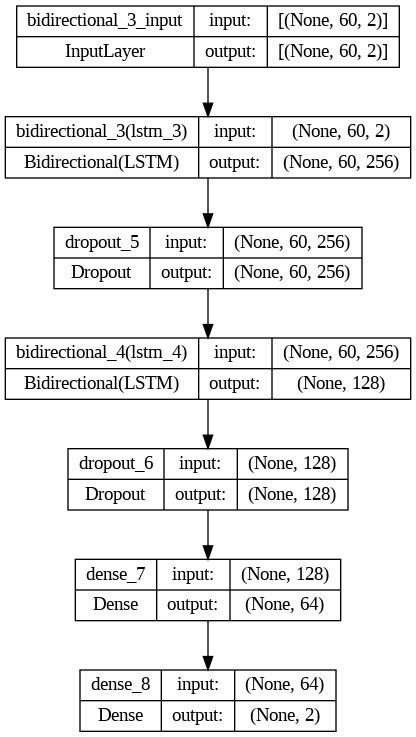

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True)

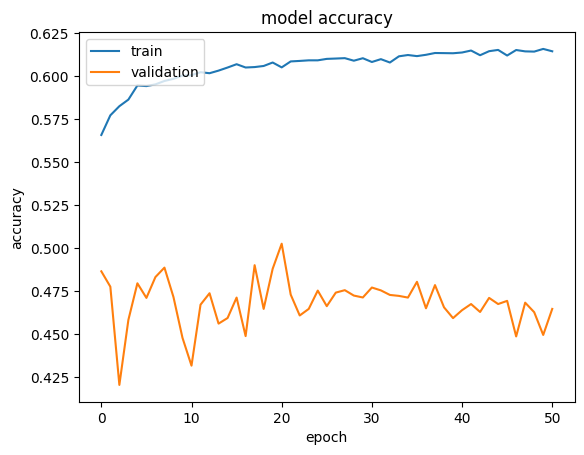

In [ ]:
plot_hist(history)

In [ ]:
model2.evaluate(x_test,y_test,verbose=1)

508/508 [==============================] - 5s 7ms/step - loss: 0.2339 - accuracy: 0.4637 - f1_m: 0.3456 - precision_m: 0.3393 - recall_m: 0.3720


[0.23386767506599426,
 0.4636833667755127,
 0.34561946988105774,
 0.3392593562602997,
 0.3720472455024719]

In [ ]:
pred = model2.predict(x_test)
print(classification_report(y_test, np.argmax(pred,axis=1)))

508/508 [==============================] - 5s 7ms/step
              precision    recall  f1-score   support

           0       0.65      0.45      0.53     10731
           1       0.33      0.52      0.40      5515

    accuracy                           0.48     16246
   macro avg       0.49      0.49      0.47     16246
weighted avg       0.54      0.48      0.49     16246



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

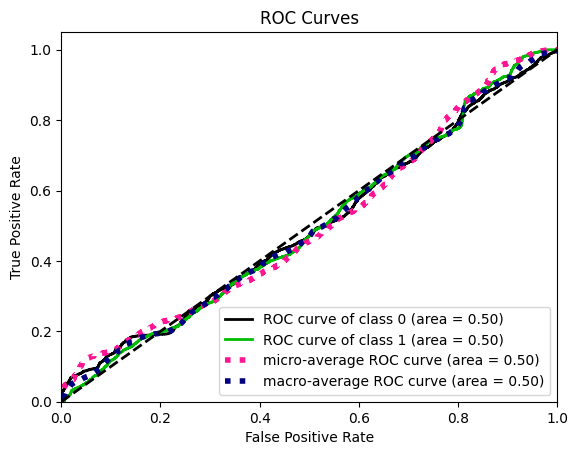

In [ ]:
skplt.metrics.plot_roc(y_test, pred)

#### Time Series Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation=partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation=partial(tf.nn.leaky_relu, alpha=0.01))(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)


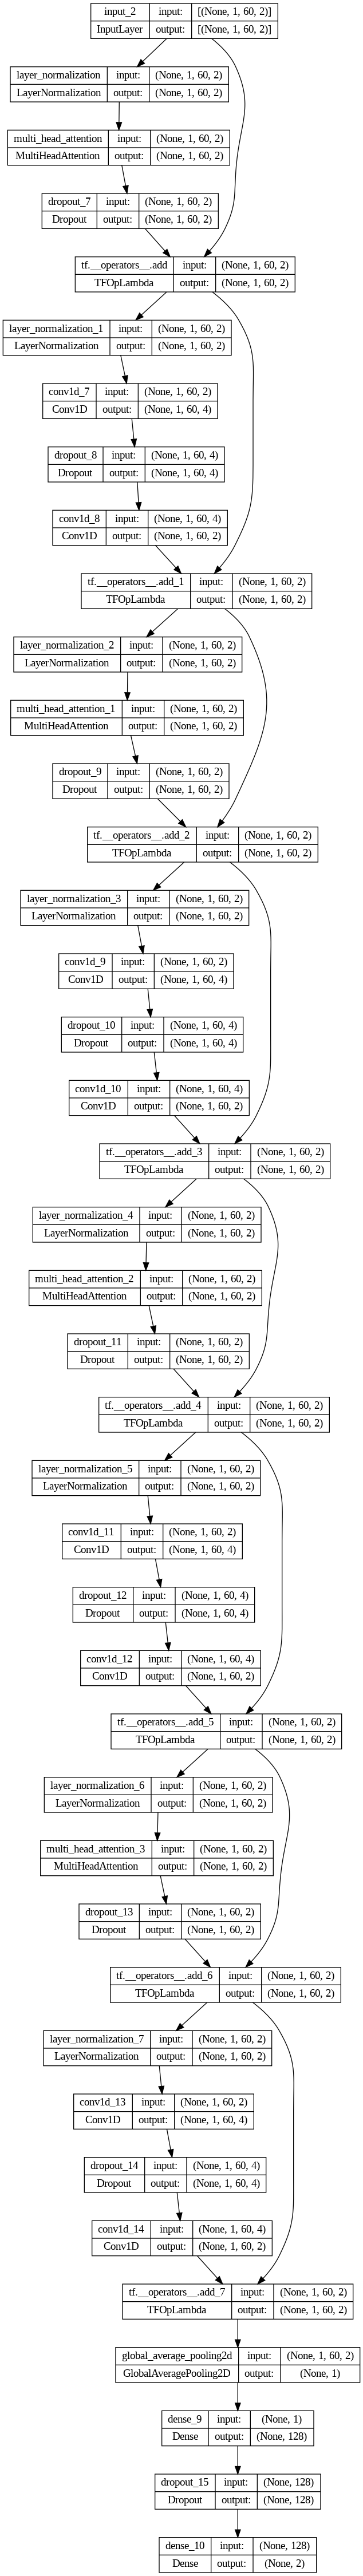

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 250
batch_size = 128

callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                           restore_best_weights=True)]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
with tf.device('/device:gpu:0'):
  history = model.fit(
      X_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks,
      class_weight = class_weights,
      validation_data=(X_val,y_val),
      verbose=1,
  )

Epoch 1/250
593/593 [==============================] - 56s 71ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.5560 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.6140
Epoch 2/250
593/593 [==============================] - 41s 69ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.5116 - val_loss: 0.6693 - val_sparse_categorical_accuracy: 0.6218
Epoch 3/250
593/593 [==============================] - 39s 66ms/step - loss: 0.6885 - sparse_categorical_accuracy: 0.5709 - val_loss: 0.6993 - val_sparse_categorical_accuracy: 0.4231
Epoch 4/250
593/593 [==============================] - 41s 70ms/step - loss: 0.6883 - sparse_categorical_accuracy: 0.5319 - val_loss: 0.6877 - val_sparse_categorical_accuracy: 0.5184
Epoch 5/250
593/593 [==============================] - 39s 66ms/step - loss: 0.6908 - sparse_categorical_accuracy: 0.5106 - val_loss: 0.6884 - val_sparse_categorical_accuracy: 0.5355
Epoch 6/250
593/593 [==============================] - 41s 70ms/step - loss: 0.6904 -

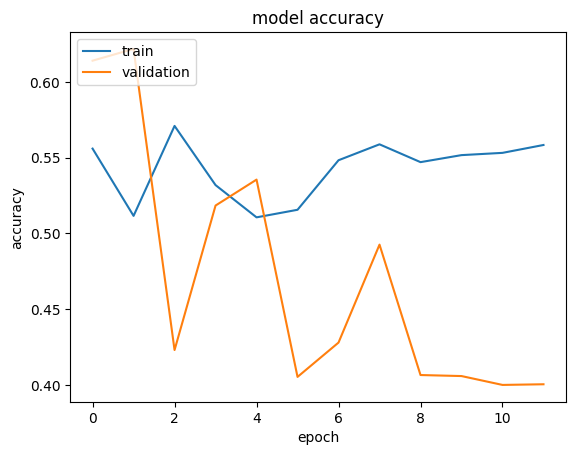

In [ ]:
plot_hist_sparse(history)

In [ ]:
model.evaluate(X_test,y_test,verbose=1)

508/508 [==============================] - 4s 9ms/step - loss: 0.6659 - sparse_categorical_accuracy: 0.6482


[0.6659220457077026, 0.6481595635414124]

In [ ]:
pred = model.predict(X_test)
print(classification_report(y_test, np.argmax(pred,axis=1)))

508/508 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

           0       0.67      0.92      0.78     10731
           1       0.43      0.12      0.19      5515

    accuracy                           0.65     16246
   macro avg       0.55      0.52      0.48     16246
weighted avg       0.59      0.65      0.58     16246



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

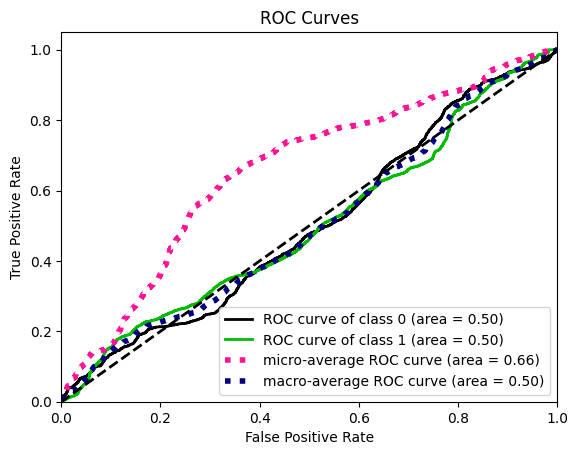

In [ ]:
skplt.metrics.plot_roc(y_test, pred)

###Machine Learning Models

Feature engineering for Machine Learning Models :Time Series transformed into primitive values like Min, Max, RMSE, Std etc..

In [ ]:
features = X_train_ml.columns
X_trainval_ml = X_trainval.drop(
    ['Target_Tplus'+str(window)+'_x', 'Target_Tplus'+str(window)+'_y', 'Label', 'Participant'], axis=1)
X_train_ml = X_train_ml.drop(
    [ 'Label', 'Participant'], axis=1)
X_test_ml = X_test_ml.drop(
    ['Label', 'Participant'], axis=1)
X_val_ml = X_val_ml.drop(
    ['Label', 'Participant'], axis=1)

#### Random Forest

In [ ]:
sc = StandardScaler()
X_trainval_ml = sc.fit_transform(X_trainval_ml)

# X_test_ml_sc = sc.transform(X_test_ml)

In [ ]:
clf = RandomForestClassifier(n_estimators=100,max_depth=15)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, X_trainval_ml, y_trainval, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.959 (0.002)


In [ ]:
sc = StandardScaler()
X_train_ml = sc.fit_transform(X_train_ml)
X_test_ml = sc.transform(X_test_ml)
X_val_ml = sc.transform(X_val_ml)

Repeated K fold Cross Validation

In [ ]:
clf = RandomForestClassifier(n_estimators=100,max_depth=15)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, X_trainval_ml, y_trainval, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.959 (0.003)


In [ ]:
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train_ml, y_train)

RandomForestClassifier(max_depth=15)

In [ ]:
y_pred = clf.predict(X_train_ml)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     50979
           1       0.99      0.95      0.97     24832

    accuracy                           0.98     75811
   macro avg       0.98      0.97      0.98     75811
weighted avg       0.98      0.98      0.98     75811



In [ ]:
y_pred = clf.predict(X_val_ml)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.69     10808
           1       0.33      0.29      0.31      5438

    accuracy                           0.57     16246
   macro avg       0.50      0.50      0.50     16246
weighted avg       0.55      0.57      0.56     16246



In [ ]:
y_pred = clf.predict(X_test_ml)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74     10731
           1       0.44      0.31      0.36      5515

    accuracy                           0.63     16246
   macro avg       0.57      0.55      0.55     16246
weighted avg       0.61      0.63      0.61     16246



Important Features used by the model

In [ ]:
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.020 seconds


In [ ]:
features = list(features)
features.remove('Label')
features.remove('Participant')

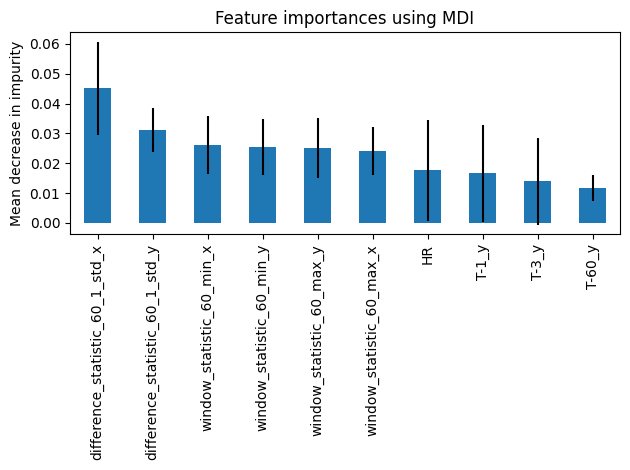

In [ ]:
forest_importances = pd.Series(importances, index=features)
dfff = pd.DataFrame(forest_importances)
dfff['std'] = std

fig, ax = plt.subplots()
dfff.sort_values(by=0, ascending =False)[:10][0].plot.bar(yerr=dfff.sort_values(by=0, 
                                          ascending =False)[:10]['std'], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Adaptive Boosting

Repeated Stratified K-Fold Cross validation

In [ ]:
clf = AdaBoostClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, X_trainval_ml, y_trainval, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.693 (0.004)


In [ ]:
clf = AdaBoostClassifier()
clf.fit(X_train_ml, y_train)

AdaBoostClassifier()

In [ ]:
y_pred = clf.predict(X_train_ml)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81     50979
           1       0.62      0.32      0.42     24832

    accuracy                           0.71     75811
   macro avg       0.68      0.61      0.61     75811
weighted avg       0.69      0.71      0.68     75811



In [ ]:
y_pred = clf.predict(X_val_ml)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70     10808
           1       0.32      0.23      0.27      5438

    accuracy                           0.58     16246
   macro avg       0.49      0.49      0.49     16246
weighted avg       0.55      0.58      0.56     16246



In [ ]:
y_pred = clf.predict(X_test_ml)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71     10731
           1       0.35      0.24      0.29      5515

    accuracy                           0.59     16246
   macro avg       0.51      0.50      0.50     16246
weighted avg       0.56      0.59      0.57     16246



Important Features used by the model

In [ ]:
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.005 seconds


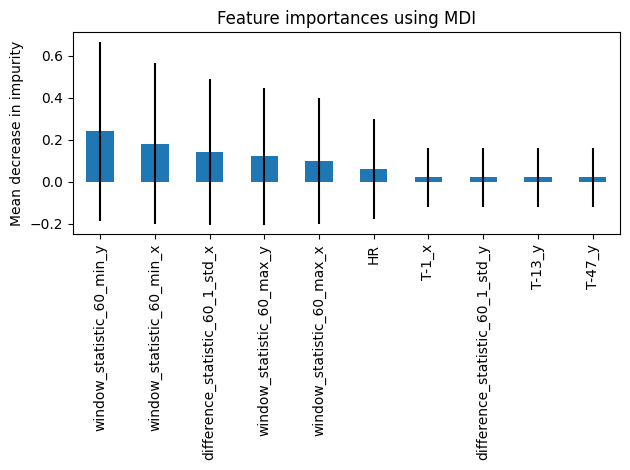

In [ ]:
forest_importances = pd.Series(importances, index=features)
dfff = pd.DataFrame(forest_importances)
dfff['std'] = std

fig, ax = plt.subplots()
dfff.sort_values(by=0, ascending =False)[:10][0].plot.bar(yerr=dfff.sort_values(by=0, 
                                          ascending =False)[:10]['std'], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()